# Building a Memory-Enhanced Email Agent with LangGraph

This tutorial demonstrates how to build an advanced AI agent with three types of memory using LangGraph and LangMem. We'll create an email assistant that can remember important facts, learn from past examples, and improve its behavior based on feedback.

## Key Memory Types:
- **Semantic Memory**: Stores facts and knowledge about contacts, preferences, and contexts
- **Episodic Memory**: Remembers specific past interactions and examples
- **Procedural Memory**: Learns and improves behavioral patterns over time

## Tutorial Overview: Email Assistant with Memory

In this tutorial, we'll build an email agent that can:

1. **Triage emails**: Classify incoming emails as 'ignore', 'notify', or 'respond'
2. **Draft responses**: Compose contextually appropriate replies using stored knowledge
3. **Learn from feedback**: Improve its performance based on user corrections

The agent will leverage all three memory types to create a system that becomes more helpful and personalized over time.



## System Workflow

<div style="text-align: center;">

<img src="../images/memory-enhanced-email-agent.svg" alt="essay grading system langgraph" style="width:80%; height:auto;">
</div>

### 1. Setting the Stage: Imports and Setup
First, the imports:

In [1]:
import os
from dotenv import load_dotenv
from typing import TypedDict, Literal, Annotated, List
from langgraph.graph import StateGraph, START, END, add_messages
from langchain.chat_models import init_chat_model
from langchain_core.tools import tool
from langchain.prompts import PromptTemplate
from langchain.schema import HumanMessage
from pydantic import BaseModel, Field
from langgraph.store.memory import InMemoryStore  # For storing memories
from langmem import create_manage_memory_tool, create_search_memory_tool # LangMem!

In [2]:
# Load environment variables (your OpenAI API key)
load_dotenv()

# Initialize the LLM
llm = init_chat_model("openai:gpt-4o-mini")

# Initialize the memory store (we'll use an in-memory store for simplicity)
store = InMemoryStore(index={"embed": "openai:text-embedding-3-small"})

/Users/adornes/Library/CloudStorage/Dropbox/Profissional/Multiplicai/repos/long-memory-agents/.venv/lib/python3.11/site-packages/langgraph/store/base/embed.py:95: LangChainBetaWarning: The function `init_embeddings` is in beta. It is actively being worked on, so the API may change.
  return init_embeddings(embed)


### 2. Defining Our Agent's "Brain": The State

In [13]:
class TriageState(TypedDict):
    email_input: dict  # The incoming email
    messages: Annotated[list, add_messages]  # The conversation history
    triage_result: str # The result of the triage (ignore, notify, respond)

### 3. The Triage Center: Deciding What to Do (with Episodic Memory!)

We'll enhance the triage step with episodic memory.

First, let's define the Router:

In [14]:
class Router(BaseModel):
    reasoning: str = Field(description="Step-by-step reasoning behind the classification.")
    classification: Literal["ignore", "respond", "notify"] = Field(
        description="The classification of an email: 'ignore', 'notify', or 'respond'."
    )

llm_router = llm.with_structured_output(Router)

Now, the enhanced triage_email function:

In [15]:
def format_few_shot_examples(examples):
    formatted_examples = []
    for eg in examples:
        email = eg.value['email']
        label = eg.value['label']
        formatted_examples.append(
            f"From: {email['author']}\nSubject: {email['subject']}\nBody: {email['email_thread'][:300]}...\n\nClassification: {label}"
        )
    return "\n\n".join(formatted_examples)

In [16]:
def triage_email(state: TriageState, config: dict, store: InMemoryStore) -> dict:
    email = state["email_input"]
    user_id = config["configurable"]["langgraph_user_id"]
    namespace = ("email_assistant", user_id, "examples")  # Namespace for episodic memory

    # Retrieve relevant examples from memory
    examples = store.search(namespace, query=str(email))
    formatted_examples = format_few_shot_examples(examples)

    triage_prompt_template = PromptTemplate.from_template("""You are an email triage assistant.  Classify the following email:
    From: {author}
    To: {to}
    Subject: {subject}
    Body: {email_thread}

    Classify as 'ignore', 'notify', or 'respond'.

    Here are some examples of previous classifications:
    {examples}
    """)

    triage_prompt = triage_prompt_template.format(examples=formatted_examples, **email)
    messages = [HumanMessage(content=triage_prompt)]
    result = llm_router.invoke(messages)
    return {"triage_result": result.classification}

### 4. Action Time: Defining Tools (with Semantic Memory!)

In [8]:
@tool
def write_email(to: str, subject: str, content: str) -> str:
    """Write and send an email."""
    print(f"Sending email to {to} with subject '{subject}'\nContent:\n{content}\n")
    return f"Email sent to {to} with subject '{subject}'"

In [9]:
@tool
def check_calendar_availability(day: str) -> str:
    """Check calendar availability for a given day."""
    return f"Available times on {day}: 9:00 AM, 2:00 PM, 4:00 PM"

In [17]:
# Create LangMem memory tools (using the configured user ID)
manage_memory_tool = create_manage_memory_tool(namespace=("email_assistant", "{langgraph_user_id}", "collection"))
search_memory_tool = create_search_memory_tool(namespace=("email_assistant", "{langgraph_user_id}", "collection"))

tools = [write_email, check_calendar_availability, manage_memory_tool, search_memory_tool]

### 5. The Response Agent: Putting It All Together (with Semantic Memory!)

In [48]:
from langgraph.prebuilt import create_react_agent

def create_response_agent_prompt(triage_state, config, store):
    messages = triage_state['messages']
    user_id = config["configurable"]["langgraph_user_id"]
    
    # Get the current response prompt from procedural memory
    system_prompt = store.get(("email_assistant", user_id, "prompts"), "response_prompt").value
    
    return [{"role": "system", "content": system_prompt}] + messages

# Try using the current API signature
response_agent = create_react_agent(
    tools=tools,
    prompt=create_response_agent_prompt,
    store=store,
    model=llm  # Using 'model' instead of 'llm'
)

### 6. Building the Graph: Connecting the Pieces

In [50]:
workflow = StateGraph(TriageState)

# Update this line to pass the store to the node
workflow.add_node("triage", lambda state, config: triage_email(state, config, store))
workflow.add_node("response_agent", response_agent)

def route_based_on_triage(state):
  if state["triage_result"] == "respond":
    return "response_agent"
  else:
    return END

workflow.add_edge(START, "triage")
workflow.add_conditional_edges("triage", route_based_on_triage,
                              {
                                  "response_agent": "response_agent",
                                  END: END
                              })

workflow.add_edge("response_agent", END)

# Compile the graph
triage_agent = workflow.compile(store=store)

#### Show the current agent

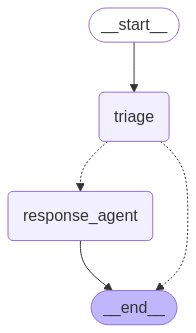

In [51]:
from langchain_core.runnables.graph import MermaidDrawMethod
from IPython.display import display, Image
 
display(
    Image(
        triage_agent.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

### 7. Adding Procedural Memory (Updating Instructions) - The Final Touch!

Procedural memory allows the agent to learn and improve its instructions. This requires a separate agent (an "optimizer") to update the prompts based on feedback:

In [54]:
initial_triage_prompt = """You are an email triage assistant. Classify the following email:
From: {author}
To: {to}
Subject: {subject}
Body: {email_thread}

Classify as 'ignore', 'notify', or 'respond'.

Here are some examples of previous classifications:
{examples}
"""

In [55]:
initial_response_prompt = """You are a helpful assistant. Use the tools available, including memory tools, to assist the user."""

In [56]:
# Store these prompts in the memory store
store.put(("email_assistant", "test_user", "prompts"), "triage_prompt", initial_triage_prompt)

In [57]:
store.put(("email_assistant", "test_user", "prompts"), "response_prompt", initial_response_prompt)

In [58]:
def triage_email_with_procedural_memory(state: TriageState, config: dict, store: InMemoryStore) -> dict:
    email = state["email_input"]
    user_id = config["configurable"]["langgraph_user_id"]
    
    # Retrieve the current triage prompt (procedural memory)
    current_prompt_template = store.get(("email_assistant", user_id, "prompts"), "triage_prompt").value
    
    # Retrieve relevant examples from memory (episodic memory)
    namespace = ("email_assistant", user_id, "examples")
    examples = store.search(namespace, query=str(email))
    formatted_examples = format_few_shot_examples(examples)
    
    # Format the prompt
    prompt = PromptTemplate.from_template(current_prompt_template).format(examples=formatted_examples, **email)
    messages = [HumanMessage(content=prompt)]
    result = llm_router.invoke(messages)
    return {"triage_result": result.classification}

In [59]:
from langmem import create_multi_prompt_optimizer

def optimize_prompts(feedback: str, config: dict, store: InMemoryStore):
    """Improve our prompts based on feedback."""
    user_id = config["configurable"]["langgraph_user_id"]
    
    # Get current prompts
    triage_prompt = store.get(("email_assistant", user_id, "prompts"), "triage_prompt").value
    response_prompt = store.get(("email_assistant", user_id, "prompts"), "response_prompt").value
    
    # Create a more relevant test example based on our actual email
    sample_email = {
        "author": "Alice Smith <alice.smith@company.com>",
        "to": "John Doe <john.doe@company.com>",
        "subject": "Quick question about API documentation",
        "email_thread": "Hi John, I was reviewing the API documentation and noticed a few endpoints are missing. Could you help? Thanks, Alice",
    }
    
    # Create the optimizer
    optimizer = create_multi_prompt_optimizer(llm)
    
    # Create a more relevant conversation trajectory with feedback
    conversation = [
        {"role": "system", "content": response_prompt},
        {"role": "user", "content": f"I received this email: {sample_email}"},
        {"role": "assistant", "content": "How can I assist you today?"}
    ]
    
    # Format prompts
    prompts = [
        {"name": "triage", "prompt": triage_prompt},
        {"name": "response", "prompt": response_prompt}
    ]
    
    try:
        # More relevant trajectories 
        trajectories = [(conversation, {"feedback": feedback})]
        result = optimizer.invoke({"trajectories": trajectories, "prompts": prompts})
        
        # Extract the improved prompts
        improved_triage_prompt = next(p["prompt"] for p in result if p["name"] == "triage")
        improved_response_prompt = next(p["prompt"] for p in result if p["name"] == "response")
        
    except Exception as e:
        print(f"API error: {e}")
        print("Using manual prompt improvement as fallback")
        
        # More specific manual improvements
        improved_triage_prompt = triage_prompt + "\n\nNote: Emails about API documentation or missing endpoints are high priority and should ALWAYS be classified as 'respond'."
        improved_response_prompt = response_prompt + "\n\nWhen responding to emails about documentation or API issues, acknowledge the specific issue mentioned and offer specific assistance rather than generic responses."
    
    # Store the improved prompts
    store.put(("email_assistant", user_id, "prompts"), "triage_prompt", improved_triage_prompt)
    store.put(("email_assistant", user_id, "prompts"), "response_prompt", improved_response_prompt)
    
    print(f"Triage prompt improved: {improved_triage_prompt[:100]}...")
    print(f"Response prompt improved: {improved_response_prompt[:100]}...")
    
    return "Prompts improved based on feedback!"

### 8. Let's Run It! (and Store Some Memories!)

In [60]:
#add few shot examples to memory
example1 = {
    "email": {
        "author": "Spammy Marketer <spam@example.com>",
        "to": "John Doe <john.doe@company.com>",
        "subject": "BIG SALE!!!",
        "email_thread": "Buy our product now and get 50% off!",
    },
    "label": "ignore",
}
store.put(("email_assistant", "test_user", "examples"), "spam_example", example1)

In [61]:
email_input = {
    "author": "Alice Smith <alice.smith@company.com>",
    "to": "John Doe <john.doe@company.com>",
    "subject": "Quick question about API documentation",
    "email_thread": """Hi John,

I was reviewing the API documentation and noticed a few endpoints are missing. Could you help?

Thanks,
Alice""",
}

config = {"configurable": {"langgraph_user_id": "test_user"}} # Set the user ID!
inputs = {"email_input": email_input, "messages": []}

for output in triage_agent.stream(inputs, config=config): # Pass the config
    for key, value in output.items():
        print(f"-----\n{key}:")
        print(value)
    print("-----")

-----
triage:
{'triage_result': 'respond'}
-----
-----
response_agent:
{'messages': [AIMessage(content='How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 306, 'total_tokens': 315, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BO5NgAJpIWIBk2XTUuzHU8JyRe0Ay', 'finish_reason': 'stop', 'logprobs': None}, id='run-1c36928d-8620-4616-9739-9d794e4fc3ae-0', usage_metadata={'input_tokens': 306, 'output_tokens': 9, 'total_tokens': 315, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
-----


### 9. Let's Run Our Complete Memory-Enhanced Agent!

In [62]:
def create_email_agent(store):
    # Define the workflow
    workflow = StateGraph(TriageState)
    workflow.add_node("triage", lambda state, config: triage_email_with_procedural_memory(state, config, store))
    
    # Create a fresh response agent that will use the latest prompts
    response_agent = create_react_agent(
        tools=tools,
        prompt=create_response_agent_prompt,
        store=store,
        model=llm
    )
    
    workflow.add_node("response_agent", response_agent)
    
    # The routing logic remains the same
    workflow.add_edge(START, "triage")
    workflow.add_conditional_edges("triage", route_based_on_triage,
                                {
                                    "response_agent": "response_agent",
                                    END: END
                                })
    
    # Compile and return the graph
    return workflow.compile(store=store)

In [63]:
# First process the original email to capture "before" behavior
print("\n\nProcessing original email BEFORE optimization...\n\n")
agent = create_email_agent(store)  # Create a fresh agent
for output in agent.stream(inputs, config=config):
    for key, value in output.items():
        print(f"-----\n{key}:")
        print(value)
    print("-----")

# Add a specific example to episodic memory
api_doc_example = {
    "email": {
        "author": "Developer <dev@company.com>",
        "to": "John Doe <john.doe@company.com>",
        "subject": "API Documentation Issue", 
        "email_thread": "Found missing endpoints in the API docs. Need urgent update.",
    },
    "label": "respond",
}
store.put(("email_assistant", "test_user", "examples"), "api_doc_example", api_doc_example)
print("Added API documentation example to episodic memory")

# Provide feedback
feedback = """The agent didn't properly recognize that emails about API documentation issues 
are high priority and require immediate attention. When an email mentions 
'API documentation', it should always be classified as 'respond' with a helpful tone.
Also, instead of just responding with 'How can I assist you today?', the agent should 
acknowledge the specific documentation issue mentioned and offer assistance."""

# Optimize prompts
optimize_prompts(feedback, config, store)

# Process the SAME email after optimization with a FRESH agent
print("\n\nProcessing the SAME email AFTER optimization with a fresh agent...\n\n")
new_agent = create_email_agent(store)  # Create a fresh agent with updated prompts
for output in new_agent.stream(inputs, config=config):
    for key, value in output.items():
        print(f"-----\n{key}:")
        print(value)
    print("-----")



Processing original email BEFORE optimization...


-----
triage:
{'triage_result': 'respond'}
-----
-----
response_agent:
{'messages': [AIMessage(content='How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 306, 'total_tokens': 315, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_0392822090', 'id': 'chatcmpl-BO5S89G136eXRxrIEQCGeyUwACOtD', 'finish_reason': 'stop', 'logprobs': None}, id='run-3d8dd474-7267-4a88-b57f-af66967379af-0', usage_metadata={'input_tokens': 306, 'output_tokens': 9, 'total_tokens': 315, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]}
-----
Added API documentation example to episodic memory
Tr

## Conclusion: From Simple Scripts to Truly Intelligent Assistants

We've now built an email agent that's far more than a simple script. Like a skilled human assistant who grows more valuable over time, our agent builds a multi-faceted memory system:

1. **Semantic Memory**: A knowledge base of facts about your work context, contacts, and preferences
2. **Episodic Memory**: A collection of specific examples that guide decision-making through pattern recognition
3. **Procedural Memory**: The ability to improve its own processes based on feedback and experience

This agent demonstrates how combining different types of memory creates an assistant that actually learns from interactions and gets better over time.